In [1]:
import itertools as its
import os
import time

import numpy as np
import pandas as pd
import us
from census import Census
from dotenv import load_dotenv
from tqdm.notebook import tqdm

from hxpr.utils import here

load_dotenv()

True

In [2]:
DATA_DIR = here() / "data"

HUD_DATA_DIR = DATA_DIR / "hud"

In [3]:
c = Census(os.environ["CENSUS_API_KEY"])

In [4]:
tract_df = pd.read_parquet(HUD_DATA_DIR / "TRACT_ZIP_092021.parquet")
zip_df = pd.read_parquet(HUD_DATA_DIR / "ZIP_COUNTY_092021.parquet")

In [5]:
all_fields = [
    "group(B01001)",
    "group(B02001)",
    "group(B03001)",
    "B22008_001E",
    "group(B06012)",
    "group(B06009)",
    "group(B27001)",
    "group(B27002)",
]

# Census won't let you do a wildcard pull on state, so just iterate
all_data = []
for state, fields in tqdm(list(its.product(us.STATES + [us.states.DC], all_fields))):
    data = c.acs5.state_county_tract(fields, state.fips, "*", "*", year=2019)
    all_data.append(data)

    # Be kind to the Census Bureau
    time.sleep(0.1)

df = pd.concat([pd.DataFrame(dat) for dat in all_data])

  0%|          | 0/408 [00:00<?, ?it/s]

In [47]:
df.columns.value_counts()

state           8
county          8
tract           8
GEO_ID          7
NAME            7
               ..
B03001_028E     1
B03001_028EA    1
B03001_028M     1
B03001_028MA    1
B27002_057MA    1
Length: 1022, dtype: int64

In [48]:
dfs = []
for i in range(0, len(all_data), len(all_fields)):
    df = pd.concat(
        [
            pd.DataFrame(datum).sort_values(by=["state", "county", "tract"])
            for datum in all_data[i : i + len(all_fields)]
        ]
    )
    dfs.append(df)

In [49]:
df = pd.concat(dfs)

In [50]:
vcs = df.columns.value_counts()
cols = vcs[vcs > 1].index

In [52]:
for col in cols:
    if not (df[col].values == df[col].iloc[:, 0].values[:, np.newaxis]).all():
        print(col)

In [54]:
df = df.copy()
df["state_abbr"] = df["state"].apply(lambda x: us.states.lookup(x).abbr)

In [55]:
tract_df["tract"].dtype

dtype('int64')

In [56]:
df["full_tract_id"] = df["state"] + df["county"] + df["tract"]
tract_df["full_tract_id"] = tract_df["tract"].apply(lambda x: f"{x:011d}")

In [57]:
merged_df = df.merge(tract_df, on="full_tract_id", how="left", indicator="_merge")

/Users/kwilso14/repo/brown/HX-PersonalResponsibility/.venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:784: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  result[self.indicator_name] = Categorical(


In [58]:
# Lost a very small number of tracts. Anything interesting about them?
merged_df["_merge"].value_counts()

both          1364848
left_only        3480
right_only          0
Name: _merge, dtype: int64

In [59]:
# Not particularly concentrated. A little odd that Michigan has so many
merged_df[merged_df["_merge"] == "left_only"].state_abbr.value_counts()

FL    464
MI    400
NY    336
CA    256
HI    224
AZ    168
WI    136
MD    112
TX    112
NC    104
LA     96
WA     96
VA     96
NJ     72
SC     72
OR     64
MA     64
NM     56
ME     56
GA     48
OH     48
NV     40
IN     32
CT     32
CO     32
RI     24
SD     24
MN     24
MS     24
KY     24
IL     24
DE     24
MT     16
AK     16
KS     16
AL     16
NH      8
PA      8
TN      8
IA      8
Name: state_abbr, dtype: int64

<AxesSubplot:>

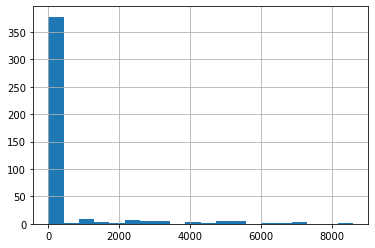

In [60]:
# Almost all of them have 0 population, so that's not super shocking
# There are some long trails, but nothing grossly large
merged_df[merged_df["_merge"] == "left_only"].B01001_001E.hist(bins=20)

In [61]:
merged_df[merged_df["_merge"] == "left_only"].B01001_001E.value_counts()

0.0       368
1268.0      2
602.0       1
1043.0      1
1663.0      1
         ... 
3073.0      1
4813.0      1
4641.0      1
67.0        1
964.0       1
Name: B01001_001E, Length: 67, dtype: int64

In [63]:
# This merges in all the data and attempts to sum it up

kept_df = merged_df[merged_df["zipcode"].notna()].copy()

In [67]:
drop_columns = [
    col for col in kept_df.columns if col.upper() == col and not col.endswith("E")
]

In [70]:
kept_df.drop(columns=drop_columns, inplace=True)

In [75]:
to_temper_cols = [
    col
    for col in kept_df.columns
    if col == col.upper() and col.endswith("E") and col != "NAME"
]

In [79]:
for field in tqdm(to_temper_cols):
    kept_df[f"tempered_{field}"] = kept_df[field] * kept_df["res_ratio"]

final_df = kept_df.groupby("zipcode")[
    [f"tempered_{field}" for field in to_temper_cols]
].sum()

  0%|          | 0/255 [00:00<?, ?it/s]

In [80]:
final_df.to_csv(DATA_DIR / "phase2" / "demographics_by_zipcode.csv.gz")